In [1]:
import sys
sys.path.append('..')

import os
import geopandas as gpd
import pandas as pd
from shapely import wkb
from rasterio.plot import show
import rasterio

from psycopg2 import sql

from sqlalchemy import create_engine, text
import collections

from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import qrcode

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm

In [2]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

ID_PROYECTO = 33457
RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [3]:
RUTA_COMPLETA

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [4]:
path_tif = r"G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - CATASTRO\RASTER\SENTINEL_2025-07-26_UTM.tif"

In [5]:
def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)

def obtener_id_labor_siguiente():
    engine = obtener_engine()
    try:
        query = """
            SELECT MAX(SPLIT_PART(id_labor, '-', 3)::int) AS mayor
            FROM drones_control_bio.parte_diario_ctrl_bio
            WHERE id_labor IS NOT NULL
        """
        df = pd.read_sql(query, engine)
        if len(df) == 0:
            return 1
        else:
            mayor = df["mayor"].iloc[0]
            return mayor + 1
    except Exception as e:
        print(f"❌ Error al optener el id_labor mayor: {e}")
        return pd.DataFrame()
    return None

def obtener_registros_id_labor(id_labor):
    engine = obtener_engine()
    try:
        query = f"""
            SELECT *
            FROM drones_control_bio.parte_diario_ctrl_bio
            WHERE id_labor = '{id_labor}'
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error al consultar id labor: {e}")
        return gdf.GeoDataFrame()
    return None

def get_recorridos_lib():
    engine = obtener_engine()
    try:
        query = """
            SELECT * FROM drones_control_bio.recorridos_lib
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error al obtener toda la capa de recorridos de control biologico: {e}")
        return pd.DataFrame()
    return None

def obtener_propiedad_de_catastro(cod_prop):
    engine = obtener_engine()
    try:
        query = f"""
                SELECT * FROM 
                catastro_iag.catastro 
                WHERE unidad_01 = {cod_prop}
            """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error al consultar unidades sin labor: {e}")
        return gpd.GeoDataFrame()
    return None

def set_id_labor(cod_prop, cod_ca, id_labor):
    engine = obtener_engine()
    try:
        with engine.begin() as conn:
            query = text("""
                UPDATE drones_control_bio.parte_diario_ctrl_bio 
                SET id_labor = :id_labor
                WHERE unidad_01 = :cod_prop
                  AND unidad_03 = :cod_ca
                  AND id_labor IS NULL
            """)
            conn.execute(query, {
                "id_labor": id_labor,
                "cod_prop": cod_prop,
                "cod_ca": cod_ca
            })
        print("✅ Actualización completada.")
    except Exception as e:
        print(f"❌ Error al actualizar id_labor: {e}")

def obtener_registros_por_unidad_01(cod_prop):
    engine = obtener_engine()
    try:
        with engine.connect() as conn:
            query = f"""
                SELECT * 
                FROM drones_control_bio.parte_diario_ctrl_bio
                WHERE id_labor IS NULL and unidad_01 = {int(cod_prop)}
            """
            gdf = gpd.read_postgis(query, conn, geom_col='geom')
            return gdf
    except Exception as e:
        print(f"❌ Error al obtener registros por unidad_01: {e}")
        return gpd.GeoDataFrame()

In [6]:
def insertar_datos_resumen(datos):
    engine = obtener_engine()

    valores = {
        'fecha': datetime.strptime(str(datos.fecha), '%d-%m-%Y').date(),
        'inst': int(datos.inst),
        'cod_ca': int(datos.cod_ca),
        'nom_ca': datos.nom_ca,
        'area_lib': float(datos.total),
        'cite': datos.id_reg,
        'cod_prop': int(datos.cod_prop),
        'nom_prop': datos.nom_prop,
        'producto': datos.producto
    }

    query = text("""
        INSERT INTO drones_control_bio.resumen_control_bio (
            fecha, institucion, cod_canero, nombre_canero, hectareas, cite, cod_propiedad, propiedad, producto
        ) VALUES (
            :fecha, :inst, :cod_ca, :nom_ca, :area_lib, :cite, :cod_prop, :nom_prop, :producto
        )
        ON CONFLICT (cite) DO UPDATE SET
            fecha = EXCLUDED.fecha,
            institucion = EXCLUDED.institucion,
            cod_canero = EXCLUDED.cod_canero,
            nombre_canero = EXCLUDED.nombre_canero,
            hectareas = EXCLUDED.hectareas,
            cod_propiedad = EXCLUDED.cod_propiedad,
            propiedad = EXCLUDED.propiedad
    """)

    with engine.begin() as conn:
        conn.execute(query, valores)

    print("✅ Registro insertado o actualizado exitosamente en RESUMEN de control biologico.")

In [7]:
ids_labor = 'CB-2025-250'
sub_propiedad = obtener_registros_id_labor(ids_labor)
len(sub_propiedad)

3

In [8]:
rec = get_recorridos_lib()

In [9]:
list_idds = list(set(sub_propiedad['idd']))
list_idds

[873]

In [10]:
data_rep = {
    'id_reg': sub_propiedad['id_labor'].iloc[0],
    'fecha' : sub_propiedad['fecha'].iloc[0].strftime('%d-%m-%Y'),
    'nom_ca' : sub_propiedad['unidad_04'].iloc[0],
    'cod_ca' : sub_propiedad['unidad_03'].iloc[0],
    'nom_prop' : sub_propiedad['unidad_02'].iloc[0],
    'cod_prop' : sub_propiedad['unidad_01'].iloc[0],
    'inst' : sub_propiedad['inst'].iloc[0],
    'total': round(sub_propiedad['area'].sum(), 2),
    'producto': str(list(set(sub_propiedad['producto']))),
        
    'temp' : sub_propiedad['temp'].iloc[0],
    'viento' : sub_propiedad['viento'].iloc[0],
    'humedad' : sub_propiedad['humedad'].iloc[0],
    'piloto1' : sub_propiedad['piloto_1'].iloc[0],
    'piloto2' : sub_propiedad['piloto_2'].iloc[0],
    'dron' : sub_propiedad['cod_dron'].iloc[0]
}

if data_rep['piloto1'] == data_rep['piloto2']:
    data_rep['piloto2'] = '-'

data_rep2 = collections.namedtuple("data", data_rep.keys())(*data_rep.values())
data_rep2

data(id_reg='CB-2025-250', fecha='12-11-2025', nom_ca='HUANCA MENCHAQUE ROLY', cod_ca=5448, nom_prop='LOS ESPINOS--ROLY HUANCA', cod_prop=905, inst='66', total=24.37, producto="['TRICHOGRAMMA']", temp=26, viento=0, humedad=70, piloto1='ALEJANDRO SANCHEZ', piloto2='', dron='DA 01')

In [11]:
categorias = sub_propiedad[['origen', 'area']]
pivot_df = categorias.pivot_table(index='origen', values='area', aggfunc='sum')
pivot_df_reset = pivot_df.reset_index()
rcategorias = []
for i, r in pivot_df_reset.iterrows():
    f = {
        'categoria' : r['origen'],
        'total' : round(r['area'], 2)
    }
    collec = collections.namedtuple("categoria", f.keys())(*f.values())
    rcategorias.append(collec)

# shape de la propiedad desde catastro
propiedad_cat = obtener_propiedad_de_catastro(data_rep2.cod_prop)
sub_propiedad = sub_propiedad.sort_values(by='unidad_05')
lotes = []
for i, r in sub_propiedad.iterrows():
    lote = {
        'nombre' : r['unidad_05'],
        'area' : round(r['area'], 2),
        'dron' : r['cod_dron'],
        'tipo' : r['origen'],
        'producto' : r['producto']
    }
    collec = collections.namedtuple("lote", lote.keys())(*lote.values())
    lotes.append(collec)

5448_905


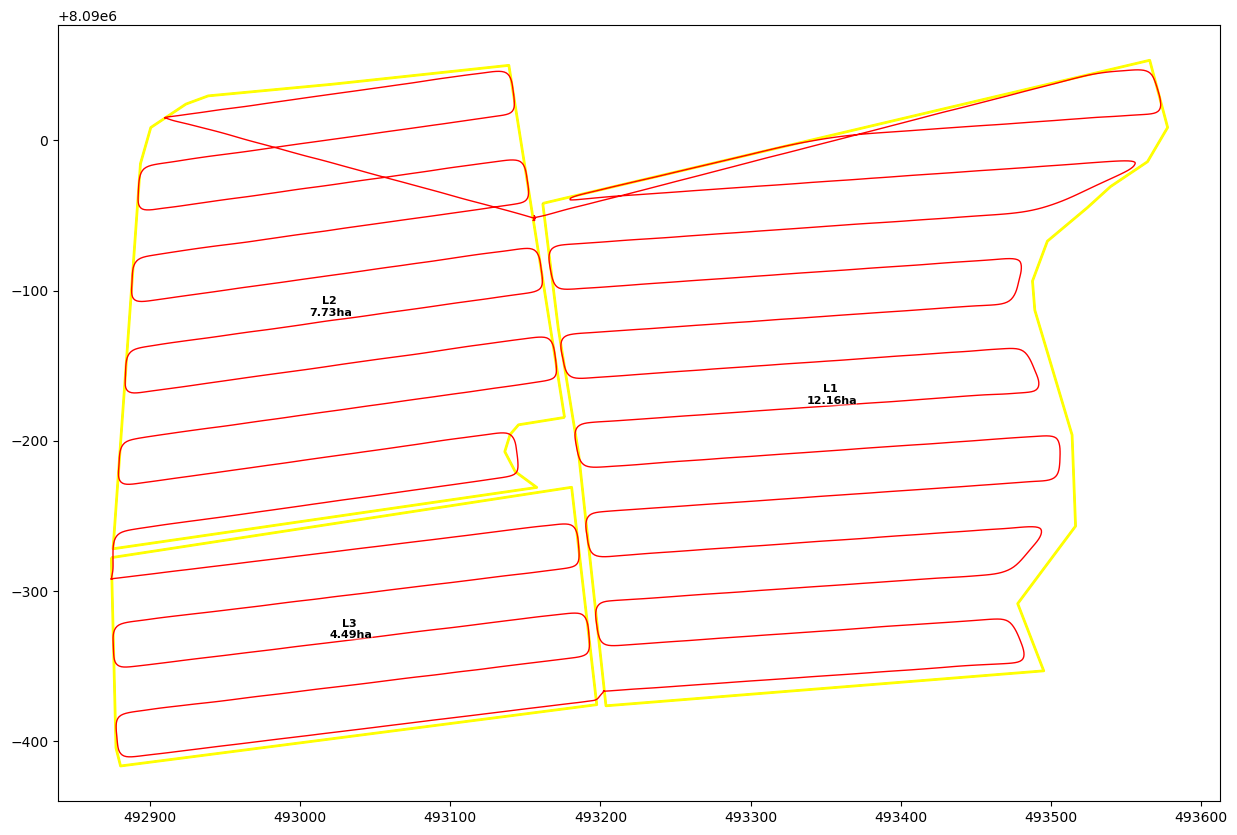

In [12]:
filename_img = str(data_rep['cod_ca']) + '_' + str(data_rep['cod_prop'])
print(filename_img)
#filtrado de la capa de recorridos
rec_filtrado = rec[rec['idd'].isin(list_idds)]
fig, ax = plt.subplots(figsize=(15, 15))
propiedad_cat.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1, label='Propiedad')
sub_propiedad.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=2, label='Aplicación')
rec_filtrado.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Recorrido Drone')

for idx, row in sub_propiedad.iterrows():
    # Representa el punto central del polígono
    centroid = row.geom.centroid
    # Anota el 'id' en el centro
    ax.annotate(
        text=row['unidad_05'] + ' \n' + str(round(row['area'], 2)) + 'ha', 
        xy=(centroid.x, centroid.y), 
        ha='center', 
        va='center', 
        weight=1000,
        fontsize=8,
        bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0))

In [13]:
bounds = propiedad_cat.total_bounds
ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
ax.set_ylim([bounds[1] - 400, bounds[3] + 400])

handle1 = Line2D([0], [0], color='blue', linewidth=1, linestyle='-', label='Lotes de propiedad')
#handle2 = mpatches.Patch(color='yellow', label='Lotes con liberacion')
handle2 = Line2D([0], [0], color='yellow', linewidth=1, linestyle='-', label='Lotes con liberacion')
handle3 = Line2D([0], [0], color='red', linewidth=1, linestyle='-', label='Recorrido Drone')

# Añade la leyenda con los handles creados
ax.legend(handles=[handle1, handle2, handle3])

# Cargar la imagen TIFF con rasterio
with rasterio.open(path_tif) as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
    img = src.read([1, 2, 3])  # Leer las bandas RGB
# Crear el plano
show(img, transform=src.transform, ax=ax)

ruta_plano = RUTA_COMPLETA + '/planos/' + filename_img + '.jpeg'
fig.savefig(ruta_plano, dpi = 300, bbox_inches='tight')
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

In [14]:
# Datos que quieres que contenga el QR
texto = '''
--UTEA--
--LIBERACION DE TRICHOGRAMMA--
        
Cod. de Liberacion: {nro_reg}
Fecha de Liberacion: {fecha}
Nombre de Canero: {canero}
Codigo Canero: {cod_ca}
Propiedad: {prop}'''\
.format(
    nro_reg=data_rep['id_reg'], 
    fecha=data_rep['fecha'], 
    canero=data_rep['nom_ca'],
    cod_ca=data_rep['cod_ca'],
    prop=data_rep['nom_prop'])
# Generar el código QR
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(texto)
qr.make(fit=True)

In [15]:
img = qr.make_image(fill_color="black", back_color="white")
    
filename_qr = 'qr_' + str(data_rep['cod_ca']) + '_' + str(data_rep['cod_prop'])
ruta_qr = RUTA_COMPLETA + '/planos/' + filename_qr + '.png'
# Guardar el código QR en un archivo
img.save(ruta_qr)

doc = DocxTemplate(RUTA_COMPLETA + "/templates/tpl_rpt_liberacion_tricho.docx")
in_line_plano = docxtpl.InlineImage(doc, image_descriptor=ruta_plano, width=Mm(150))
in_line_qr = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
context = {'data':data_rep2, 'lotes':lotes, 'rcat':rcategorias, 'plano':in_line_plano, 'qr':in_line_qr}
doc.render(context)
filename = str(data_rep['cod_ca']) + '_SLCB_' + data_rep['fecha'] + '_' + data_rep['nom_ca'] + '_' + str(data_rep['id_reg'])
doc.save(RUTA_COMPLETA + '/informes/_' + filename + '.docx')